In [1]:
from utils import *



In [2]:
_base_location = r'/Users/rahuladlakha/Documents/Github/Code_books/Forecasting_Principle_and_Practices/Data/data_fpp2_csv'

In [3]:
def ansett_parse_week(week):
    y = int(week[:4])
    w = int(week[-2:])
    return pd.to_datetime(y, format='%Y') + pd.to_timedelta(w, 'w')

In [4]:
ansett = pd.read_csv(_base_location+'/ansett.csv',
                     parse_dates=['Week'], date_parser=ansett_parse_week)

In [5]:
ansett.drop(['Unnamed: 0'], axis=1, inplace=True)


In [6]:
melsyd_economy = ansett.query("Airports == 'MEL-SYD' and Class == 'Economy'").set_index('Week')

In [7]:
melsyd_economy

,Airports,Class,Passengers
Week,,,
1987-07-02,MEL-SYD,Economy,20167
1987-07-09,MEL-SYD,Economy,20161
1987-07-16,MEL-SYD,Economy,19993
1987-07-23,MEL-SYD,Economy,20986
1987-07-30,MEL-SYD,Economy,20497
...,...,...,...
1992-10-28,MEL-SYD,Economy,28837
1992-11-04,MEL-SYD,Economy,26548
1992-11-11,MEL-SYD,Economy,27279


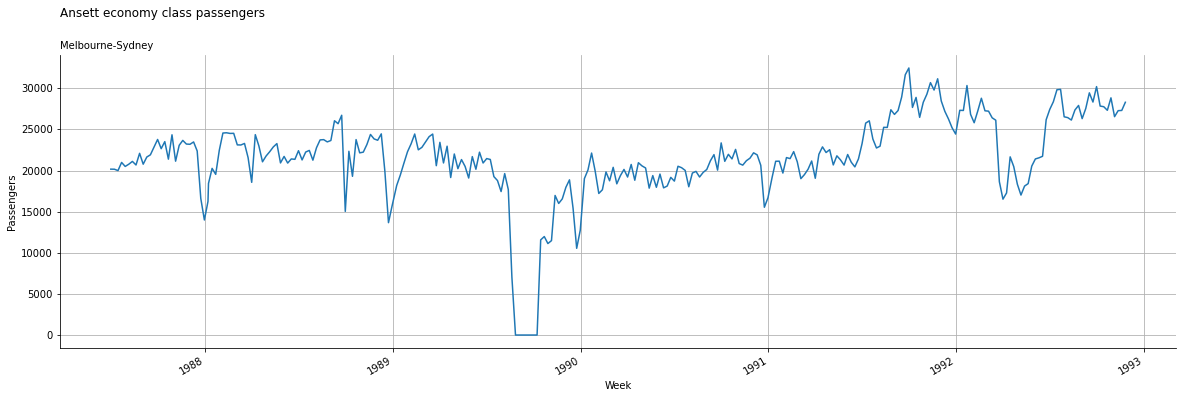

In [8]:
ax = melsyd_economy.Passengers.plot(figsize=sizets)
suptitle('Ansett economy class passengers')
ax.set(ylabel='Passengers', title='Melbourne-Sydney')
ax.grid()

In [9]:
a10 = pd.read_csv(_base_location+'/a10.csv', parse_dates=['index'])

In [10]:
a10

,index,value
0,1991-07-01,3.526591
1,1991-08-01,3.180891
2,1991-09-01,3.252221
3,1991-10-01,3.611003
4,1991-11-01,3.565869
...,...,...
199,2008-02-01,21.654285
200,2008-03-01,18.264945
201,2008-04-01,23.107677
202,2008-05-01,22.912510


In [11]:
a10=a10.groupby(by=a10['index']).sum(['value'])

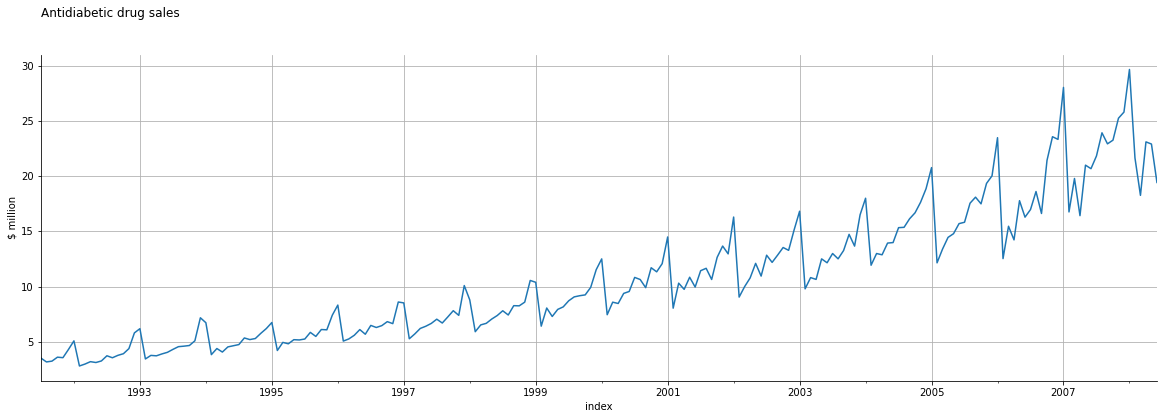

In [12]:
ax = a10.value.plot(figsize=sizets)
suptitle('Antidiabetic drug sales')
ax.set(ylabel='$ million')
ax.grid()

There is a clear and increasing trend. 

There is also a strong seasonal pattern that increases in size as the level of the series increases. 

The sudden drop at the start of each year is caused by a government subsidisation scheme that makes it cost-effective for patients to stockpile drugs at the end of the calendar year. Any forecasts of this series would need to capture the seasonal pattern, and the fact that the trend is changing slowly.

**Trend** : A trend exists when there is a long-term increase or decrease in the data.
It does not have to be linear. Sometimes we will refer to a trend as "changing direction", when it might go from an increasing trend to a decreasing trend. 


**Seasonal:** A seasonal pattern occurs when a time series is affected by seasonal factors such as the time of the year or the day of the week. 

Seasonality is always of a fixed and known period. The monthly sales of drug shows seasonality which is induced partly by the change in the cost of the drug at the end of the calendar year.

**Cyclic:** A cycle occurs when the data exhibits rises and falls that are not of a fixed frequency. These fluctuations are usually due to economic conditions, and are often related to the business cycle. The duration of thse fluctuation is usually atleast 2 years.

Many people confuse cyclic behaviour with seasonal behaviour, but they are really quite different.

If the fluctuations are not of a fixed frequency then they are cyclic; if the frequency is unchanging and associated with some aspect of the calendar, then the pattern is seasonal. In general, the average length of cycle is longer than the length of a seasonal pattern, and the magnitudes of cucles tned to be more variable than the magnitudes of seasona patterns.

Many times series include trend, cycles and seasonality. When choosing a foreasting method, we will first need to identify the time series patterns in the data, and then choose a method that is able to capture the patterns properly.

### Seasonal Plots

A seasonal plot is similar to a time plot except that the data are plotted against the individual “seasons” in which the data were observed. 

In [13]:
def seasonalize(data, column, period='year'):
    if period.lower() in ('year', 'y'):
        d = data.assign(
            __period = data.index.year,
            __x = data.index.dayofyear)
    elif period.lower() in ('week', 'w'):
        d = data.assign(
            __period = 100*data.index.year + data.index.week,
            __x = data.index.dayofweek
                + (data.index.hour + data.index.minute/60 + data.index.second/3600) / 24)
    elif period.lower() in ('day', 'd'):
        d = data.assign(
            __period = data.index.date,
            __x = data.index.hour + data.index.minute/60 + data.index.second/3600)
    d = (
        d
        .sort_values('__x')
        .groupby('__period')
        .pipe(summarize, lambda x: {'time': list(x.__x), column: list(x[column])})
    )
    return d


In [14]:
def plot_seasonal(
        data, column,
        period='year',
        cmap='viridis',
        labels='',
        figsize=None,
        ax=None,
        **kw):
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    else:
        fig, ax = ax.figure, ax
    d = seasonalize(data, column, period)
    cm = plt.get_cmap(cmap)
    for (i, p) in enumerate(d.index):
        color = cm(i / len(d))
        x, y = d.time.loc[p], d[column].loc[p]
        ax.plot(x, y, color=color, label=str(p), **kw)
        if labels in 'right both'.split():
            ax.text(x[-1], y[-1], str(p), color=color, ha='center', va='center')
        if labels in 'left both'.split():
            ax.text(x[0], y[0], str(p), color=color, ha='center', va='center')
    return ax

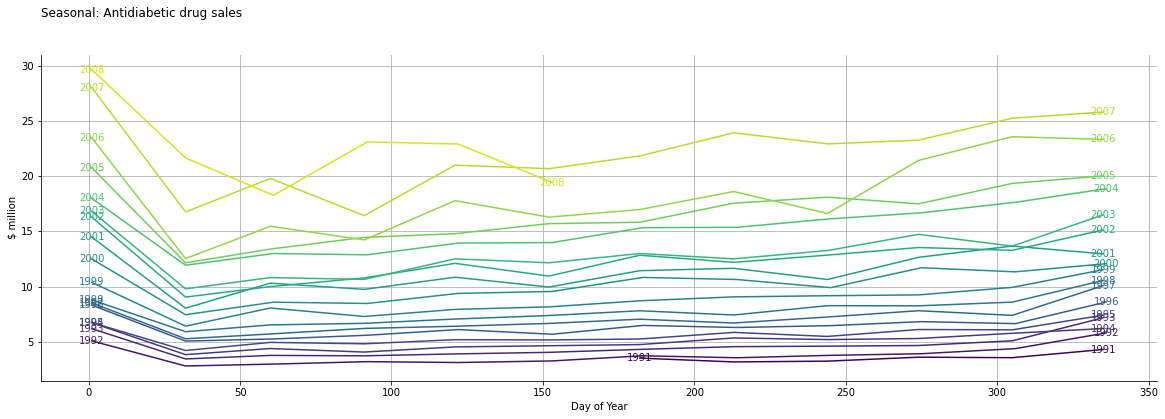

In [16]:
ax = plot_seasonal(a10, 'value', labels='both', figsize=sizets)
suptitle('Seasonal: Antidiabetic drug sales')
ax.set(xlabel='Day of Year', ylabel='$ million')
ax.grid()

 A seasonal plot allows the underlying seasonal pattern to be seen more clearly, and is especially useful in identifying years in which the pattern changes.

In this case, it is clear that there is a large jump in sales in January each year. Actually, these are probably sales in late December as customers stockpile before the end of the calendar year, but the sales are not registered with the government until a week or two later.

The graph also shows that there was an unusually small number of sales in March 2008 (most other years show an increase between February and March). The small number of sales in June 2008 is probably due to incomplete counting of sales at the time the data were collected.


### Multiple seasonal periods

In [43]:
vic_elec = (
    pd.read_csv(_base_location+'/vic_elec.csv')
    .pipe(compute, lambda x: dict(Time = pd.to_datetime(x.Time)))
    .set_index('Time')
)

The **vic_elec** data contains half-hourly electricity demand for the state of Victoria, Australia. We can plot the daily pattern, weekly pattern or yearly pattern by specifying the period

In [44]:
vic_elec.drop(['Unnamed: 0'], axis=1, inplace=True)

In [45]:
vic_elec

,Demand,Temperature,Date,Holiday
Time,,,,
2012-01-01 00:00:00,4382.825174,21.40,2012-01-01,True
2012-01-01 00:30:00,4263.365526,21.05,2012-01-01,True
2012-01-01 01:00:00,4048.966046,20.70,2012-01-01,True
2012-01-01 01:30:00,3877.563330,20.55,2012-01-01,True
2012-01-01 02:00:00,4036.229746,20.40,2012-01-01,True
...,...,...,...,...
2014-12-31 21:30:00,3873.448714,19.00,2014-12-31,False
2014-12-31 22:00:00,3791.637322,18.50,2014-12-31,False
2014-12-31 22:30:00,3724.835666,17.70,2014-12-31,False


CPU times: user 677 ms, sys: 57.3 ms, total: 734 ms
Wall time: 758 ms


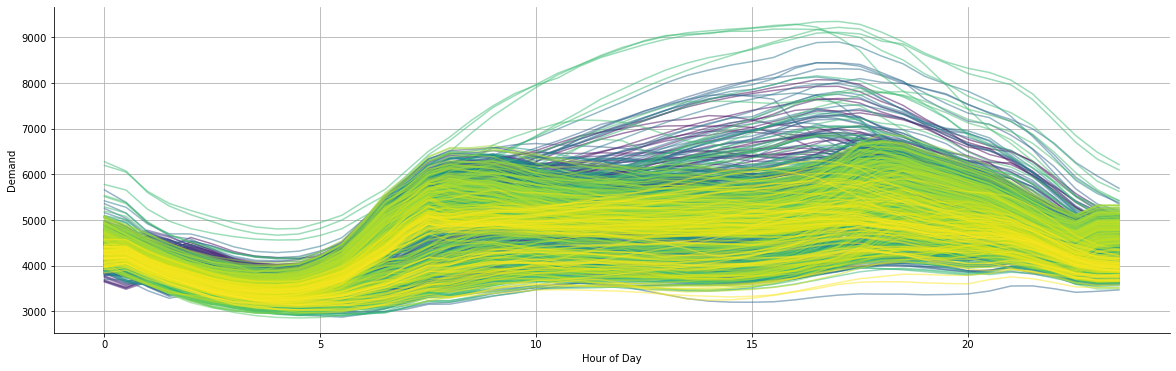

In [46]:
%%time
ax = plot_seasonal(vic_elec, 'Demand', period='d', alpha=.5, figsize=sizets)
ax.set(xlabel='Hour of Day', ylabel='Demand')
ax.grid()

/var/folders/fn/gllvw1z179nb4gb993sqkg9h0000gn/T/ipykernel_26659/1679784394.py:8: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  __period = 100*data.index.year + data.index.week,


CPU times: user 128 ms, sys: 6.61 ms, total: 135 ms
Wall time: 134 ms


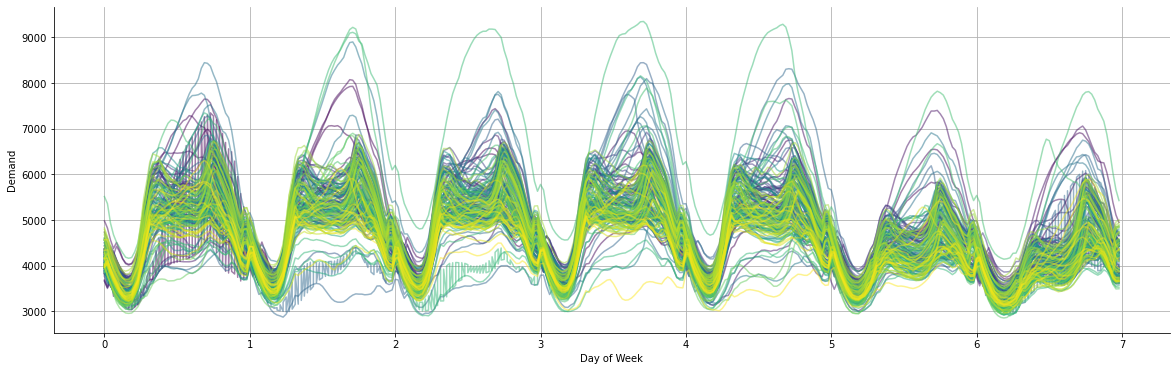

In [47]:
%%time
ax = plot_seasonal(vic_elec, 'Demand', period='w', alpha=.5, figsize=sizets)
ax.set(xlabel='Day of Week', ylabel='Demand')
ax.grid()

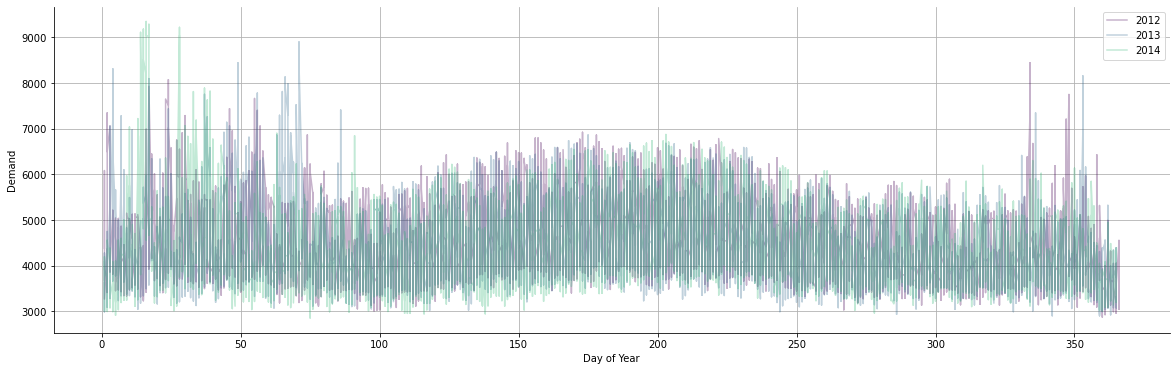

In [48]:
ax = plot_seasonal(vic_elec, 'Demand', period='y', alpha=.3, figsize=sizets)
ax.legend()
ax.set(xlabel='Day of Year', ylabel='Demand')
ax.grid()